In [ ]:
# Install the needed libraries
%pip install --upgrade pip
%pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html optax flax

In [1]:
from typing import Callable, Tuple, Optional, Union, List, Any
from dataclasses import dataclass, field
import jax
from jax import random, grad, vmap, jit, value_and_grad
from functools import partial
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import flax
from flax import linen as nn
from flax.training.train_state import TrainState
import optax
import time
import datetime


## The problem at hand

We will now solve the 2D Helmholtz equation given by:

$$\Delta u + k^2 u = q(x, y), \mbox{with } (x,y) \in [-1,1]^2 $$

with homogeneous Dirichlet boundary conditions.

When $k$ is wave number, the forcing term is given by:

$$ q(x,y) = 2 \pi k \cos{(\pi k y)} \sin{(\pi k x)} + 2 \pi k \cos{(\pi k x)} \sin{(\pi k y)} + k^2(x + y) \sin{(\pi k x)} \sin{(\pi k y)} - 2 \pi^2 k^2 (x+y) \sin{(\pi k x)} \sin{\pi k y}$$

while the exact solution is given by:

$$ u(x, y) = (x+y) \sin{(c_1 \pi k x)} \sin{(c_2 \pi k y)}$$


The example was taken from https://arxiv.org/abs/1906.01170

## Approximating the system's behavior using a Neural Network

## Codificador Posicional
O codificador posicional transforma as entradas do modelo adicionando funções seno e cosseno de diferentes frequências. Para uma entrada 
$x$, o codificador gera:
$$enc(x) = [x, sin(2^0 \pi x), cos(2^0 \pi x), sin(2^1 \pi x), cos(2^1 \pi x),...,sin(2^L \pi x), cos(2^L \pi x)]$$
$L$ é o número de níveis harmônicos.

Esse processo aumenta a capacidade do modelo de resolver padrões de alta frequência, como os encontrados em equações diferenciais como Helmholtz.

In [2]:
def positional_encoding(inputs, L=10):
    """
    Aplica codificação posicional aos inputs.
    
    Parameters:
        inputs: jnp.ndarray
            Entrada original (e.g., x ou y).
        L: int
            Número de níveis de frequências harmônicas.

    Returns:
        jnp.ndarray:
            Entrada codificada posicionalmente.
    """
    encoded = [inputs]  # Incluímos o valor original
    for i in range(L):
        freq = 2 ** i * jnp.pi
        encoded.append(jnp.sin(freq * inputs))
        encoded.append(jnp.cos(freq * inputs))
    return jnp.concatenate(encoded, axis=-1)  # Concatena tudo


### Neural Network

In [3]:
rng_key_d = random.PRNGKey(4)
def _get_activation(activation_name):
    activations = {**jax.nn.__dict__, **jnp.__dict__}
    if activation_name in activations:
        return activations[activation_name]
    else:
        raise NotImplementedError("This activation function is not implemented yet!")

class DenseLayer(nn.Module):
    features: int
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        kernel = self.param(
            "kernel",
            self.kernel_init, 
            (x.shape[-1], self.features),
        )

        bias = self.param("bias", self.bias_init, (self.features,))

        return jnp.dot(x, kernel) + bias

class Mlp(nn.Module):
    arch_name: Optional[str] = "Mlp"
    num_layers: int = 4
    layer_size: int = 64
    out_dim: int = 1
    activation: str = "tanh"
    lb: List = field(default_factory=List)
    ub: List = field(default_factory=List)
    harmonic_levels: int = 10 # Número de frequências no codificador posicional
    extra_params: Any = None

    def setup(self):
        self.activation_fn = _get_activation(self.activation)
        self.lb_array = jnp.asarray(self.lb)
        self.ub_array = jnp.asarray(self.ub)

    @nn.compact
    def __call__(self, *inputs):
        # Normalize the inputs
        x = (
            2.0 * (jnp.stack(inputs) - self.lb_array) / (self.ub_array - self.lb_array)
           - 1.0
        )
        # Aplica codificação posicional
        x = positional_encoding(x, L=self.harmonic_levels)

        for _ in range(self.num_layers):
            x = DenseLayer(features=self.layer_size)(x)
            x = self.activation_fn(x)

        # Output layer
        x = DenseLayer(features=self.out_dim)(x)

        return x.flatten()

## The batch sampler

This time, let's implement a sampler so we can obtain the PDE residual evaluation points randomly

In [4]:
class Helmholtz2DSampler(object):
    def __init__(self, batch_size, dom_bds, rng_key):
        self.batch_size = batch_size
        self.key = rng_key
        self.dom_bds = dom_bds

    def __getitem__(self, index):
        self.key, subkey = random.split(self.key)
        batch = self.data_generation(subkey)
        return batch

    @partial(jit, static_argnums=(0,))
    def data_generation(self, key):
        key1, key2 = random.split(key)
        # Points for evaluating the PDE residual
        x = random.uniform(
            key1,
            shape=(self.batch_size,),
            minval=self.dom_bds["xmin"],
            maxval=self.dom_bds["xmax"],
        )
        y = random.uniform(
            key2,
            shape=(self.batch_size,),
            minval=self.dom_bds["ymin"],
            maxval=self.dom_bds["ymax"],
        )

        return {
            "x": x,
            "y": y,
            "xmin": self.dom_bds["xmin"],
            "xmax": self.dom_bds["xmax"],
            "ymin": self.dom_bds["ymin"],
            "ymax": self.dom_bds["ymax"],
        }

# Agendador de taxa de aprendizado

Agendador de taxa de aprendizado (learning rate schedule) com aquecimento (warmup) e decaimento exponencial (exponential decay):

**Implementação do Scheduler**

Use a função optax.join_schedules para combinar um período de warmup com o decaimento exponencial.

**Explicação**

* __Warmup__ (`linear_schedule`): Aumenta linearmente a taxa de aprendizado de `init_value` para `peak_value` nos primeiros `warmup_steps`.

* __Decaimento Exponencial__ (`exponential_decay`): Após o período de warmup, a taxa de aprendizado decai exponencialmente com a fórmula:

    $learning\ rate = peak\ value \cdot (decay\ rate)^{step/decay\ steps}$
 
* __Combinação__ (`join_schedules`): Une os dois agendadores e aplica o warmup antes do decaimento.


In [5]:
def create_warmup_exponential_decay_schedule(
    init_value=1e-6,
    peak_value=1e-3,
    warmup_steps=1000,
    decay_rate=0.98,
    decay_steps=5000,
):
    """
    Cria um agendador de taxa de aprendizado com warmup seguido por decaimento exponencial.
    """
    # Agendador para a fase de warmup
    warmup_schedule = optax.linear_schedule(
        init_value=init_value,
        end_value=peak_value,
        transition_steps=warmup_steps,
    )

    # Agendador para o decaimento exponencial
    decay_schedule = optax.exponential_decay(
        init_value=peak_value,
        transition_steps=decay_steps,
        decay_rate=decay_rate,
    )

    # Combinar warmup e decaimento exponencial
    schedule = optax.join_schedules(
        schedules=[warmup_schedule, decay_schedule],
        boundaries=[warmup_steps],
    )

    return schedule


# Train

In [6]:
# Define the train step function
@jit
def train_step(state, batch, k, u_max):

    def pde_residual_fn(params, x, y):

        u = state.apply_fn(params, x, y)
        u_xx = grad(grad(state.apply_fn, 1), 1)(params, x, y)
        u_yy = grad(grad(state.apply_fn, 2), 2)(params, x, y)

        q = (
            2.0 * jnp.pi * k * jnp.cos(jnp.pi * k * y) * jnp.sin(jnp.pi * k * x)
            + 2.0 * jnp.pi * k * jnp.cos(jnp.pi * k * x) * jnp.sin(jnp.pi * k * y)
            + k**2 * (x + y) * jnp.sin(jnp.pi * k * x) * jnp.sin(jnp.pi * k * y)
            - 2.0 * jnp.pi**2 * k**2 *(x + y) * jnp.sin(jnp.pi * k * x) * jnp.sin(jnp.pi * k * y)
        )/u_max
        res = (u_xx + u_yy) + k**2 * u - q 
        return res

    # Define the loss function
    def loss_fn(params, batch):

        res_pred = vmap(pde_residual_fn, (None, 0, 0))(params, batch["x"], batch["y"])
        pde_loss = jnp.square(res_pred).mean()

        u_west = vmap(state.apply_fn, (None, None, 0))(
            params, batch["xmin"], batch["y"]
        )

        u_east = vmap(state.apply_fn, (None, None, 0))(
            params, batch["xmax"], batch["y"]
        )

        u_north = vmap(state.apply_fn, (None, 0, None))(
            params, batch["x"], batch["ymax"]
        )

        u_south = vmap(state.apply_fn, (None, 0, None))(
            params, batch["x"], batch["ymin"]
        )

        data_loss = (
            jnp.square(u_west).mean()
            + jnp.square(u_east).mean()
            + jnp.square(u_north).mean()
            + jnp.square(u_south).mean()
        )

        total_loss = 20.0 * data_loss + pde_loss

        return total_loss, {
            "total_loss": total_loss,
            "data_loss": data_loss,
            "pde_loss": pde_loss,
        }

    # Compute the loss and its grads w.r.t. the model parameters
    (_, loss_components), grads = value_and_grad(loss_fn, has_aux=True)(
        state.params, batch
    )
    state = state.apply_gradients(grads=grads)
    return loss_components, state


@jit
def eval_step(state, batch, x, y):
    def l2_error(params, batch):
        u_pred = vmap(vmap(state.apply_fn, (None, None, 0)), (None, 0, None))(
            params, x, y
        )
        return jnp.linalg.norm(x=(u_pred.flatten() - batch["u"].flatten()), ord=2) / jnp.linalg.norm(
            x=batch["u"].flatten(), ord=2
        )

    return l2_error(state.params, batch)

In [8]:
def helmholtz_2d(k = 1, n = 101, xb = [-1, 1], yb=[-1, 1]):
    u_true_fn = lambda x, y: (x + y) * jnp.sin(jnp.pi * k * x) * jnp.sin(jnp.pi * k * y)

    du_dx_0_fn = lambda y: jnp.pi * k * y * jnp.sin(jnp.pi * k * y)
    du_dy_0_fn = lambda x: jnp.pi * k * x * jnp.sin(jnp.pi * k * x)

    q_fn = (
        lambda x, y: 2.0 * jnp.pi *k * jnp.cos(jnp.pi * k * y) * jnp.sin(jnp.pi * k * x)
        + 2.0 * jnp.pi * k * jnp.cos(jnp.pi * k * x) * jnp.sin(jnp.pi * k * y)
        + k**2 * (x + y) * jnp.sin(jnp.pi * k * x) * jnp.sin(jnp.pi * k * y)
        - 2.0 * jnp.pi**2 * k**2 * (x + y) * jnp.sin(jnp.pi * k * x) * jnp.sin(jnp.pi * k * y)
    )

    x = jnp.linspace(xb[0], xb[1], n)
    y = jnp.linspace(yb[0], yb[1], n)

    u_true = vmap(vmap(u_true_fn, (None, 0)), (0, None))(x, y)
    q = vmap(vmap(q_fn, (None, 0)), (0, None))(x, y)
    u_max = jnp.max(u_true)
    q_max = jnp.max(q)
    return {
        "x": x,
        "y": y,
        "u_true": u_true,
        "u_true_norm": u_true / u_max,
        "u_max": u_max,
        "forcing_term": q,
    }


# Graphics

In [9]:
def helmholtz_graf(x, y, u_true, u_pred, k, ep, timelapse):
    fig, axs = plt.subplots(1, 3, figsize=(10, 10 / 1.618))
    
    im = axs[0].contourf(x, y, u_true, levels=128, cmap="jet")
    fig.colorbar(im, ax=axs[0], location='bottom', ticks=np.linspace(u_true.min(), u_true.max(), 5))
    axs[0].set_title(r"$u_{true}(x,y)$")
    
    im = axs[1].contourf(x, y, u_pred, levels=128, cmap="jet")
    fig.colorbar(im, ax=axs[1], location='bottom', ticks=np.linspace(u_pred.min(), u_pred.max(), 5))
    axs[1].set_title(r"$u_{pred}(x,y)$")
    
    error = jnp.abs(u_pred-u_true)
    im = axs[2].contourf(x, y, error, levels=128, cmap="jet")
    fig.colorbar(im, ax=axs[2], location='bottom', ticks=np.linspace(error.min(), error.max(), 5))
    axs[2].set_title(r"$|err(x,y)|$")
    
    for ax in axs:
        ax.set_aspect("equal")
    
    fig.tight_layout()
    fig.suptitle("Prediction AFTER training the model")
    plt.savefig(f'results/helmholtz_k{k}EPL{ep}.jax.png')

    a = sum(error)/len(error)
    b = sum(a)/len(a)

    formatted_time = str(datetime.timedelta(seconds=int(timelapse)))
    
    print(f"time:{formatted_time} error: {b}")
    with open(f"results/helmholtz_k{k}EPL{ep}.log","w") as file:
        file.write(f"time:{formatted_time} error: {b}")

In [10]:
def helmholtz_error_graf(total_loss_log, data_loss_log, pde_loss_log, error_log, k, ep):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10 / 1.618))
    epoch_log = jnp.linspace(0, ep, len(total_loss_log))
    ax.plot(epoch_log, total_loss_log, label="Total Loss")
    ax.plot(epoch_log, data_loss_log, label="Data Loss")
    ax.plot(epoch_log, pde_loss_log, label="PDE Loss")
    ax.plot(epoch_log, error_log, label="Error")
    
    ax.set_yscale("log")
    ax.legend()
    plt.savefig(f'results/helmholtz_error_k{k}EPL{ep}.jax.png')

In [11]:

def helmholtz_init_graf(x,y,u_true,q):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10 / 1.618), sharex=True, sharey=True)
    
    axs[0].contourf(x, y, u_true, levels=128, cmap="jet")
    axs[0].set_title(r"$u_{true}(x,y)$")
    axs[1].contourf(x, y, q, levels=128, cmap="jet")
    axs[1].set_title(r"$q(x,y)$")
    
    for ax in axs:
        ax.set_aspect("equal")

# Main

In [12]:
def multigrid_training(state, rng_key, k, resolutions, n_ep = 5000, xdom=[-1,1], ydom=[-1,1]):
    total_loss_log = []
    data_loss_log = []
    pde_loss_log = []
    epoch_log = []
    error_log = []
    
    #####################################################################
    batch_acc = len(resolutions) - 1 if len(resolutions) > 1 else 1
    rng_key, subkey = random.split(rng_key)
    start = time.time()
    # Loop over resolutions
    for resolution in resolutions:
        print(f"Training at resolution: {resolution}x{resolution}")

        # Generate data for this resolution
        hmt = helmholtz_2d(k, resolution)
        x, y, u_true_n, u_max = hmt["x"], hmt["y"], hmt["u_true_norm"], hmt["u_max"]

        sampler = Helmholtz2DSampler(
            batch_size=int(256 + resolution/(batch_acc)) ,
            dom_bds={"xmin": xdom[0], "xmax": xdom[1], "ymin": ydom[0], "ymax": ydom[1]},
            rng_key=subkey,
        )
        batch_iterator = iter(sampler)

        eval_batch = {"x": x, "y": y, "u": u_true_n}
        for epoch in range(n_ep):
            train_batch = next(batch_iterator)
            loss, state = train_step(state, train_batch,k, u_max)
            if epoch % 200 == 0:
                l2_error = eval_step(state, eval_batch, x, y)
        
                epoch_log.append(epoch)
                total_loss_log.append(loss["total_loss"])
                data_loss_log.append(loss["data_loss"])
                pde_loss_log.append(loss["pde_loss"])
                error_log.append(l2_error)
                # l2_error = 0
                print(
                    f"Epoch: {epoch} -- Total Loss: {loss['total_loss']}  -- Data Loss: {loss['data_loss']} -- PDE Loss: {loss['pde_loss']}  -- Error: {l2_error}"
                )

    #####################################################################
    hmt["timelapse"] = time.time() - start
    hmt["u_pred"] = vmap(vmap(state.apply_fn, (None, None, 0)), (None, 0, None))(
        state.params, x, y
    )
    ret = {
        "total_loss_log":total_loss_log,
        "data_loss_log":data_loss_log,
        "pde_loss_log":pde_loss_log,
        "epoch_log":epoch_log,
        "error_log":error_log
    }
    return hmt, ret

In [13]:
# Initialize the random key
rng_key = random.PRNGKey(42)

# Define domain
xmin, xmax = -1, 1
ymin, ymax = -1, 1

# Define the Neural Network
model = Mlp(num_layers=5, layer_size=200, out_dim=1, activation = "tanh",
            lb=[xmin, ymin], ub=[xmax, ymax], harmonic_levels=3)

# Initialize the model parameters
rng_key, init_key = random.split(rng_key, 2)
dummy_input = jnp.asarray(0.0)
params = model.init(init_key, dummy_input, dummy_input)

## Define the optimizer using Optax
# The learning rate scheduler
lr = create_warmup_exponential_decay_schedule(
init_value=1e-6, peak_value=1e-3, warmup_steps=500,
decay_steps=2000, decay_rate=0.98)

tx = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=lr)
)

# Create the training state
state = TrainState.create(
    apply_fn=lambda params_, x_, y_: model.apply(
        params_, x_, y_)[0],
    params=params,
    tx=tx,
)

## Exemplo com Multigrid + Pré-treinamento + Codificador Harmonico

O pré-treino do modelo é obtido pelo treinamento do $k$ anterior, ou seja $k=2$ é pré-treinamento de $k=5$ e assim por diante. `resolutions` é o array que define o multigrid sendo que após um periodo especifico (`epoch`) a malha é refinada. 

O codigicador harmonico já esta predefinido na rede neural.

Training at resolution: 100x100
Epoch: 0 -- Total Loss: 1778.776611328125  -- Data Loss: 0.4157963991165161 -- PDE Loss: 1770.460693359375  -- Error: 1.3679336309432983
Epoch: 200 -- Total Loss: 13.349552154541016  -- Data Loss: 0.0945623368024826 -- PDE Loss: 11.458305358886719  -- Error: 0.2601390480995178
Epoch: 400 -- Total Loss: 9.655726432800293  -- Data Loss: 0.022079719230532646 -- PDE Loss: 9.214132308959961  -- Error: 0.1430734097957611
Epoch: 600 -- Total Loss: 6.992163181304932  -- Data Loss: 0.017172804102301598 -- PDE Loss: 6.648706912994385  -- Error: 0.15290631353855133
Epoch: 800 -- Total Loss: 4.258812427520752  -- Data Loss: 0.008206719532608986 -- PDE Loss: 4.094677925109863  -- Error: 0.1558326929807663
Epoch: 1000 -- Total Loss: 2.647557258605957  -- Data Loss: 0.004803314805030823 -- PDE Loss: 2.5514910221099854  -- Error: 0.08652547001838684
Epoch: 1200 -- Total Loss: 2.226560592651367  -- Data Loss: 0.003943524323403835 -- PDE Loss: 2.1476900577545166  -- Error

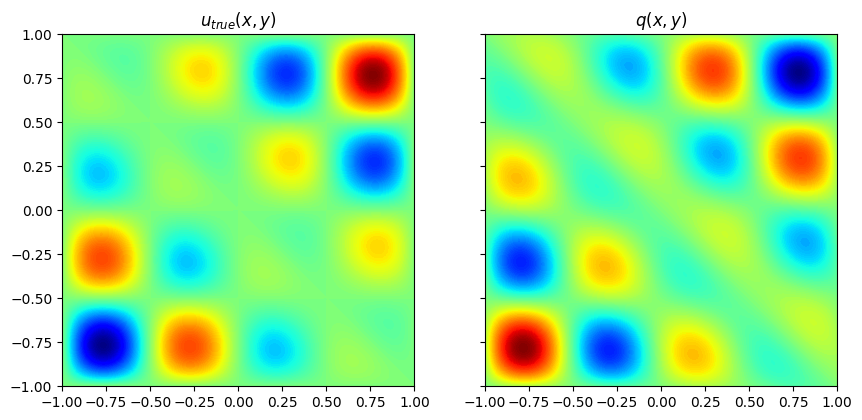

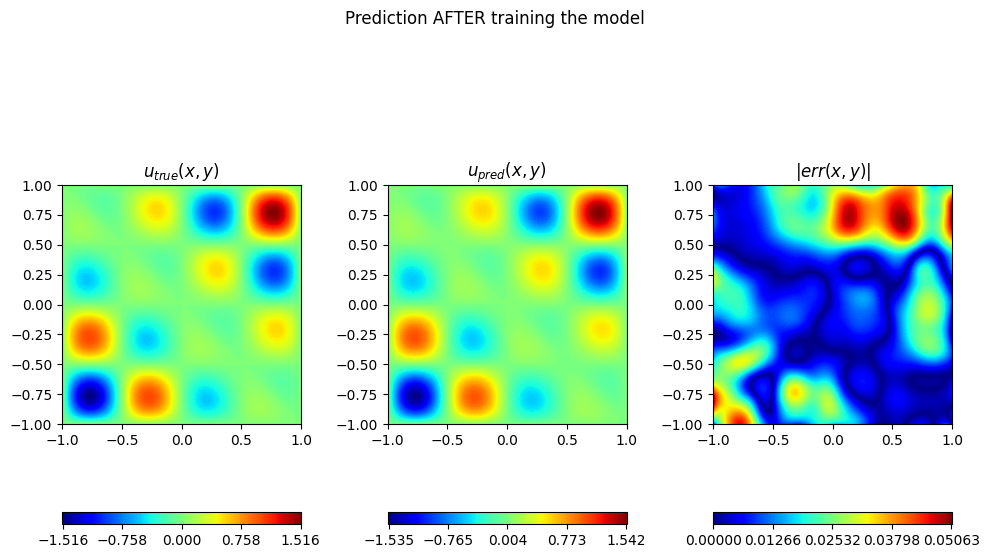

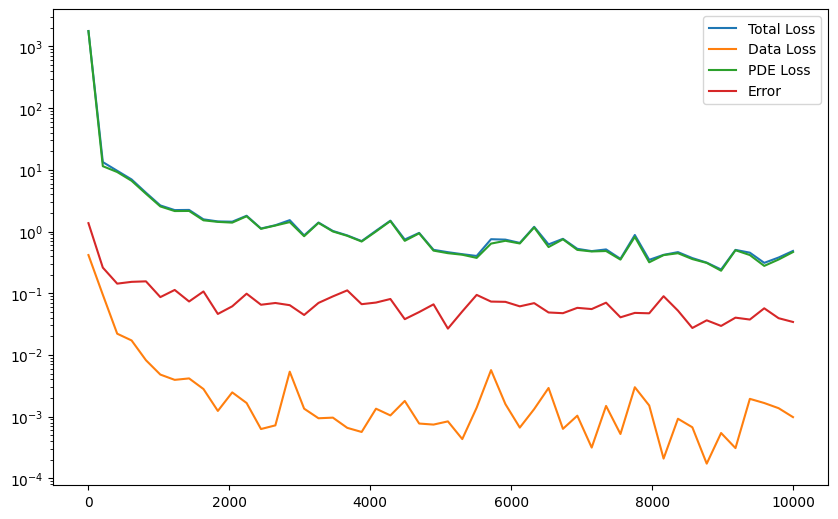

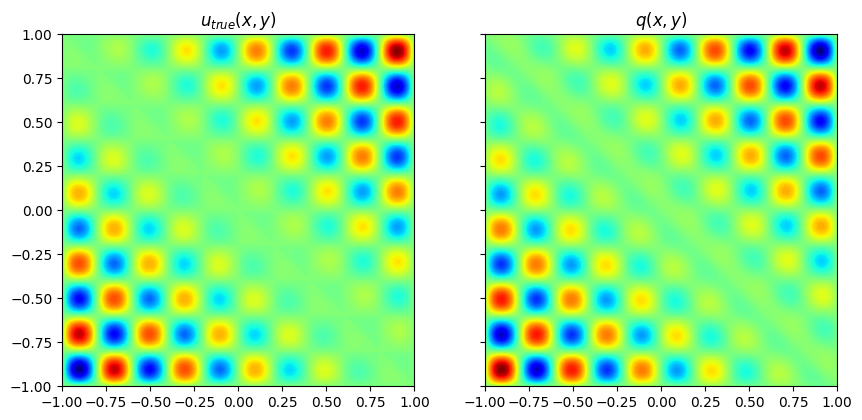

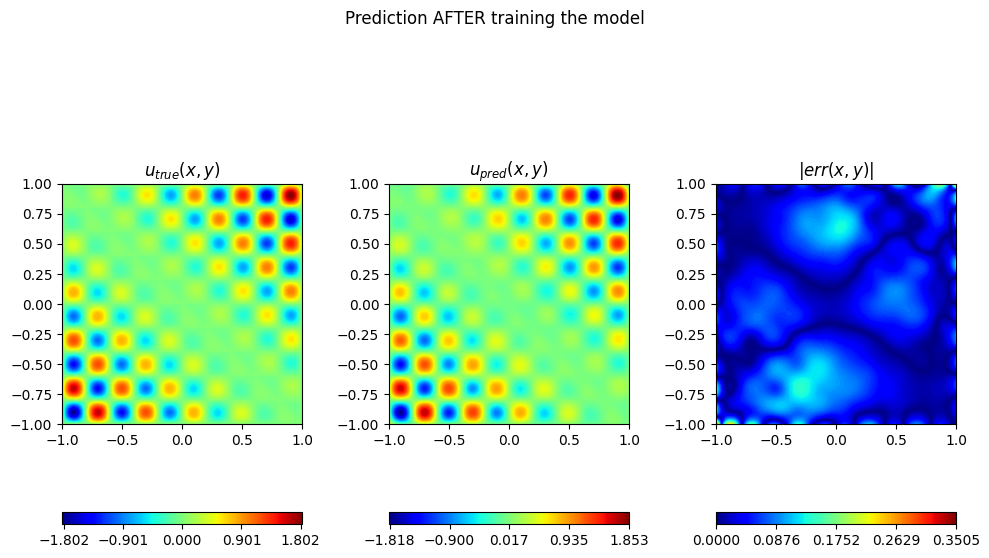

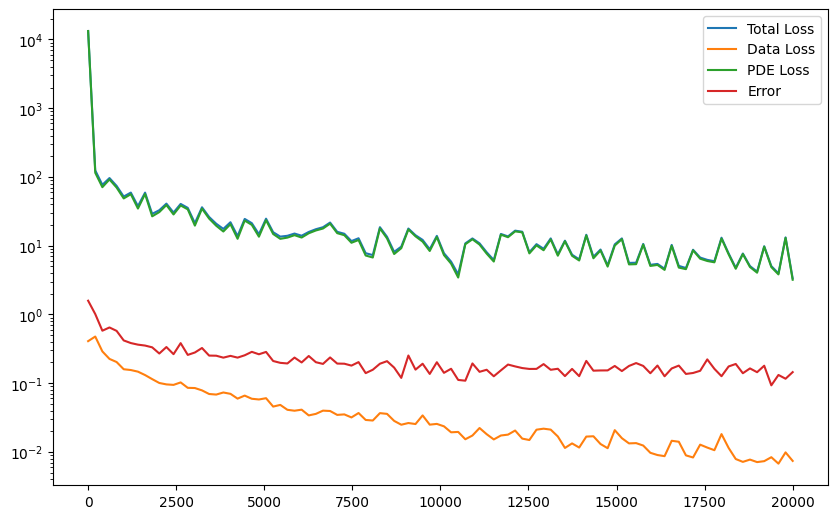

In [15]:
ks = [2, 5, 7, 10]

# Defina as resoluções em ordem crescente
resolutions=[100, 200, 400, 800, 1000, 1200]
epoch = 5000
epoch_levels = len(resolutions)*epoch
for k in ks:
    hmt, ret = multigrid_training(state=state, rng_key=rng_key, k=k, 
                                     resolutions=resolutions, n_ep = epoch, xdom=[xmin, xmax], ydom=[ymin, ymax])
    
    x, y, t, u_true, u_pred, q = hmt["x"], hmt["y"], hmt["timelapse"], hmt["u_true"], hmt["u_max"]*hmt["u_pred"], hmt["forcing_term"]
    
    helmholtz_init_graf(x,y,u_true,q)
    helmholtz_graf(x, y, u_true, u_pred, k, epoch_levels, t)
    helmholtz_error_graf(ret["total_loss_log"], ret["data_loss_log"], ret["pde_loss_log"], ret["error_log"], k, epoch_levels)